In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# İs Cuda Available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def read_images(path,num_img):
    array = np.zeros([num_img,64*32])
    i = 0
    for image in os.listdir(path):
        img_path = path + "\\" + image
        if image.endswith(".png"):
            img = Image.open(img_path, mode="r")
            data = np.asarray(img, dtype="uint8")
            data = data.flatten()
            array[i,:] = data
            i += 1
    return array    
    

In [4]:
train_neg_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Train\neg"
train_pos_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Train\pos"

pos_nums = 10208
neg_nums = 43390

pos_train_array = read_images(train_pos_path,pos_nums)
neg_train_array = read_images(train_neg_path,neg_nums)

In [5]:
x_pos_train_tensor = torch.from_numpy(pos_train_array) #pozitif resimleri numpy arrayden torch tensora çevirdik

y_pos_train_tensor =torch.ones(pos_nums,dtype=torch.long) #pozitif resimler boyutu kadar 1 lerden oluşan bir tensor

print(y_pos_train_tensor.size())

x_neg_train_tensor = torch.from_numpy(neg_train_array) #negatif resimleri numpy arrayden torch tensora çevirdik

y_neg_train_tensor =torch.zeros(neg_nums,dtype=torch.long) #negatif resimler boyutunda 0 lardan oluşan bir tensor

print(y_neg_train_tensor.size())


torch.Size([10208])
torch.Size([43390])


In [6]:
x_train = torch.cat((x_neg_train_tensor,x_pos_train_tensor),0) #pozitif ve negatif train verilerini x_train adıyla birleştirdik
y_train = torch.cat((y_neg_train_tensor,y_pos_train_tensor),0) #kendi oluşturduğumuz 1 ve 0 lardan oluşan tensorları y_train adıyla birleştirdik
print(x_train.size())

print(y_train.size())

torch.Size([53598, 2048])
torch.Size([53598])


In [8]:
test_neg_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Test\neg"
test_pos_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Test\pos"

pos_test_nums = 5944
neg_test_nums = 22050

neg_test_array = read_images(test_neg_path,neg_test_nums)
pos_test_array = read_images(test_pos_path,pos_test_nums)


In [9]:
x_pos_test_tensor = torch.from_numpy(pos_test_array) #poztif test verilerini numpy arrayden torch tensore çevirdik

y_pos_test_tensor =torch.ones(pos_test_nums,dtype=torch.long) #pozitif test verileri için 1 lerden oluşan tensor

print(y_pos_test_tensor.size())

x_neg_test_tensor = torch.from_numpy(neg_test_array) #negatif test verilerini numpy arrayden torch tensore çevirdik
    
y_neg_test_tensor =torch.zeros(neg_test_nums,dtype=torch.long) #negatif test verileri için 0 lerden oluşan tensor

print(y_neg_test_tensor.size())


torch.Size([5944])
torch.Size([22050])


In [10]:
x_test = torch.cat((x_neg_test_tensor,x_pos_test_tensor),0) #pozitif ve negatif train verilerini x_test adıyla birleştirdik
y_test = torch.cat((y_neg_test_tensor,y_pos_test_tensor),0) #kendi oluşturduğumuz 1 ve 0 lardan oluşan tensorları y_train adıyla birleştirdik
print(x_test.size())

print(y_test.size())

torch.Size([27994, 2048])
torch.Size([27994])


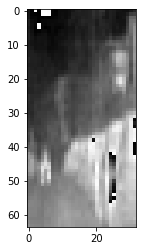

In [11]:
plt.imshow(x_train[12000,:].reshape(64,32),cmap="gray")
plt.show() 

In [15]:
num_epochs = 5
num_classes = 2
batch_size = 2 
lr = 0.0001


class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        
    
        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,16,5)
        
        self.fc1 = nn.Linear(16*13*5,520)
        self.fc2 = nn.Linear(520,130)
        self.fc3 = nn.Linear(130,num_classes)
    def forward(self,x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = x.view(-1,16*13*5)
        
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
from torch.utils import data
    
train = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

test = torch.utils.data.TensorDataset(x_test,y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [16]:
nnet = net()

criterion = nn.CrossEntropyLoss()

import torch.optim as optim 
optimizer = optim.SGD(nnet.parameters(), lr=lr, momentum=0.8)

In [18]:
start = time.time()

total_step = len(train_loader)
train_acc = []
test_acc = []
loss_list = []




gpu = False

for epoch in range(num_epochs):
    for i,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs = inputs.view(batch_size,1,64,32)
        inputs = inputs.float()
        
        
        optimizer.zero_grad()
        
        outputs = nnet(inputs)
        
        loss = criterion(outputs,labels)
        
        loss.backward()
        
        optimizer.step()
        
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            
            images = images.view(batch_size,1,64,32)
            images =images.float()
            
            outputs = nnet(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 2 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
    acc1 = 100*correct/total
    print("test accuarcy : ",acc1)
    test_acc.append(acc1)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            images,labels = data
            
            images = images.view(batch_size,1,64,32)
            images =images.float()
            
            outputs = nnet(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc2 = 100*correct/total
    print("train accuarcy : ",acc2)
    train_acc.append(acc2)

    
print("Train is done")
    
finish = time.time()

processing_time = (finish-start)/60
print("processing time : ",processing_time)

test accuarcy :  93.30213617203687
train accuarcy :  99.67536102093362
test accuarcy :  94.28806172751304
train accuarcy :  99.73693048248069
test accuarcy :  92.88061727513039
train accuarcy :  99.85447218179783
test accuarcy :  93.49503465028221
train accuarcy :  99.97387962237397
test accuarcy :  93.19497035078946
train accuarcy :  99.98693981118699
Train is done
processing time :  68.94741425116857
